<a href="https://colab.research.google.com/github/gsangf10/KNN_Algorithm/blob/main/KNN_Regression_Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제
- 가장 상관관계가 높은 특성을 찾아서 최근접 이웃 회귀로 성능지표를 확인하고 집값을 예측하기


In [68]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore') # 경고무시

# 데이터셋 호출
bos = load_boston()
data =  bos.data # 데이터
h_price =  bos.target # 집값
feature_names = bos.feature_names # 특성이름

df = pd.DataFrame(data, columns=feature_names)

# 특성 뜻
# CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
# NOX: 일산화질소 농도
# RM: 거주할 수 있는 방 개수
# AGE: 1940년 이전에 건축된 소유 주택의 비율
# DIS: 5개 주요 고용센터까지의 가중 거리
# RAD: 고속도로 접근 용이도
# TAX: 10,000달러당 재산세
# PTRATIO: 지역의 교사와 학생 수 비율
# B: 지역의 흑인 거주 비율
# LSTAT: 하위 계층의 비율
# PRICE: 본인 소유의 주택 가격(중앙값) - 종속변수 (위의 건 독립변수)


# 상관관계별 시각화

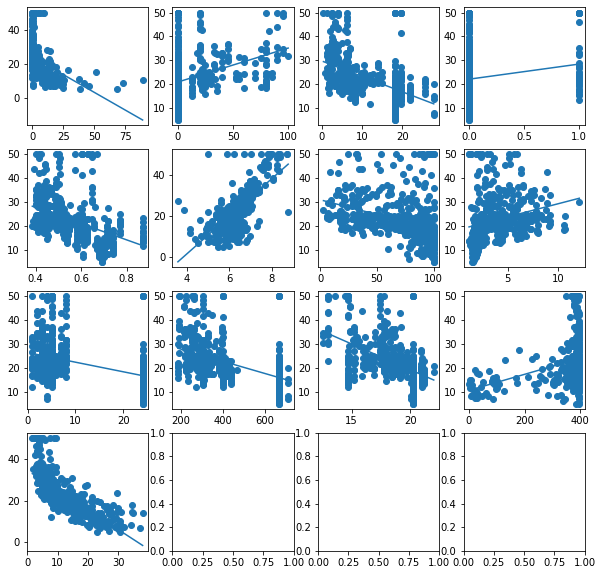

In [69]:
# 상관관계가 높은 특성 찾기
max_slope, max_intercept = 0, 0
slt_data = None
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

def get_1dim_slope(x, coef, intercept):
  return coef * x + intercept

for i in range(len(feature_names)):
  col_data = df.iloc[:,i].values
  coef, intercept = np.polyfit(col_data, h_price, 1)
  
  # 산점도와 그래프 표시
  row, col = i // 4, i % 4

  x_min = np.min(col_data)
  x_max = np.max(col_data)
  y_min = get_1dim_slope(x_min, coef, intercept)
  y_max = get_1dim_slope(x_max, coef, intercept)

  axes[row, col].scatter(col_data, h_price)
  axes[row, col].plot([x_min, x_max], [y_min, y_max])

  if coef > max_slope:
    max_slope, max_intercept = coef, intercept
    slt_data = col_data
  
# 차원 변환
h_price = h_price.reshape(-1, 1)
slt_data = slt_data.reshape(-1, 1)


# 선택된 특성 시각화

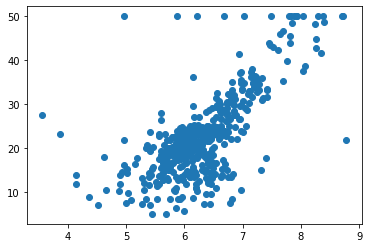

In [70]:
# 선택된 특성의 데이터
plt.scatter(slt_data, h_price)

# KNN Regression Analysis (회귀 분석)

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

train_d, test_d, train_t, test_t = train_test_split(slt_data, h_price) # 75% 학습 데이터 25% 정답 데이터

lr = LinearRegression()
# lr = KNeighborsRegressor()

# lr.fit(train_d, train_t)
# lr.score(train_d, train_t), lr.score(test_d, test_t)
# lr.predict([[test_x]])

# 과대적합, 과소적합을 해소하는 방법
# 과소적합 -> 특성(feature)을 추가하거나, 회귀식의 0차수를 높인다.
# 과대적합 -> 차수를 낮추거나 특성의 가중치(기울기, 회귀계수)를 낮춘다.

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False) # defualt : degree(차수) = 2

# 가장 알맞은 기울기 차수 구하기
for i in range(1,30):
  poly.degree = i
  poly.fit(train_d, train_t)
  # poly.get_feature_names_out()

  trd_poly = poly.transform(train_d)
  tst_poly = poly.transform(test_d)

  lr.fit(trd_poly, train_t)
  if lr.score(trd_poly, train_t) >= 0.6 and lr.score(tst_poly, test_t) >= 0.55:
    break
    
print(poly.degree, lr.score(trd_poly, train_t), lr.score(tst_poly, test_t))


12 0.6048689783027472 0.5619128183879937


# 학습 정확도 0.85 이상, 테스트 정확도 0.80 이상 달성

In [72]:
# 특성을 선별해서 feature 엔지니어링을 통해 좀 더 디테일하게 학습 시킨다.

coef_list = []

for feature in df.columns.values :

  train_d = df[[feature]].values

  lr = LinearRegression()
  lr.fit(train_d, h_price)
  lr.coef_, lr.intercept_ # ax + b 
  
  coef_list.append(lr.coef_[0])

s = pd.Series(coef_list, index=df.columns)

s = pd.Series.abs(s)

s = s.sort_values(ascending=False)

cols = s.index.values[:6] # 상관도가 높은 6개의 특성을 선별하여 진행
df2 = df[cols]

trd, tsd, trt, tst = train_test_split(df2, h_price, random_state=44)

poly.degree = 2
poly.fit(trd, trt)
poly.get_feature_names_out()
trd_poly = poly.transform(trd)
tsd_poly = poly.transform(tsd)

lr.fit(trd_poly, trt)
lr.score(trd_poly, trt), lr.score(tsd_poly, tst) # 차수 2에서 학습 0.86, 테스트 0.84 정도의 정확도를 갖는다.

(0.8579655962410245, 0.8477537425449477)